In [71]:
import numpy as np
import copy 
import time
import random
import math

In [72]:
def str_arr(arr):
    strng = ""
    for obj in arr: 
        if type(obj) is type(""):
            strng += obj + " "   
        else:
            strng += "%.5f" % obj + " "
    return strng

In [308]:

class Bittensor:
    
    def __init__(self):
        self.stake = {} # id --> stake
        self.edges = {} # id --> edges.
        self.emit_height = {} # id --> last emit block.
        self.block_height = 0 # chain height.
        self.total = 0
        
    def subscribe(self, this_identity):
        self.stake[this_identity] = 1
        self.edges[this_identity] = [(this_identity, 1.0)]
        self.emit_height[this_identity] = self.block_height
        self.block_height += 1
        self.total += 1
        
    def emit(self, this_identity, edges, inc_height=True):
        assert(edges[0][0] == this_identity)
        assert(abs(sum([w for i, w in edges]) - 1.0) < 0.001 )
                
        this_emission = self._get_emission(this_identity)
        self._do_emit(this_identity, this_emission)
               
        self.edges[this_identity] = edges
        self.emit_height[this_identity] = self.block_height
        if inc_height:
            self.block_height += 1

    # Bitcoin emission approx.
    def _get_emission(self, this_identity):
        EMIT_RATE = 1
        delta_blocks = self.block_height - self.emit_height[this_identity]    
        this_emission = EMIT_RATE * delta_blocks * (math.log(self.stake[this_identity]) / math.log(self.total))
        return this_emission + 0.01
               
    def _do_emit(self, this_identity, this_emission):
               
        # Recurse the emmision through the tree.
        emission_queue = [(this_identity, this_emission)]
        while len(emission_queue) > 0:
            
            # Next.
            current_identity, current_emission = emission_queue.pop()
            current_inedge = self.edges[current_identity][0][1]
            self.stake[current_identity] += (current_emission * current_inedge) 
            self.total += (current_emission * current_inedge)
            
            # Recurse.
            for next_identity, next_weight in self.edges[current_identity][1:]:
                next_emission = current_emission * next_weight                
                if next_emission > 0.001:
                    emission_queue.append((next_identity, current_emission * next_weight)) 
                                   
        
    def __str__(self):
        strng = "" 
        strng += "S: " + str_arr([self.stake[identity] for identity in self.stake.keys()]) + "\n" 
        return strng

In [325]:
def matrix_approximation(nodes, edges):
    
    # In edge weights.
    N = np.array([edges[n][0][1] for n in nodes], dtype=np.float32)
    
    # Adjacency Matrix
    M = []
    for n in nodes:
        column = [0 for _ in range(len(nodes))]
        for e in edges[n]:
            if e[0] != n:
                column[nodes.index(e[0])] = e[1]
        M.append(column)
    M = np.transpose(np.array(M, dtype=np.float32))
    
    # Initial Stake per node.
    S = np.array([1, 
              1,
              1,
              1,
              1], dtype=np.float32)

    # Attribution calculation.
    A = np.multiply(S, N)
    T = np.matmul(M, S)

    depth = 1000
    for _ in range(depth):
        A += np.multiply(T, N)
        T = np.matmul(M, T)
    A = A / np.linalg.norm(A, 1)
    
    return list(A)


Matrix Approximation Attribution: 0.21972 0.27324 0.12394 0.18310 0.20000 
Trial Attribution: 0.21613 0.28676 0.11429 0.17702 0.20566 


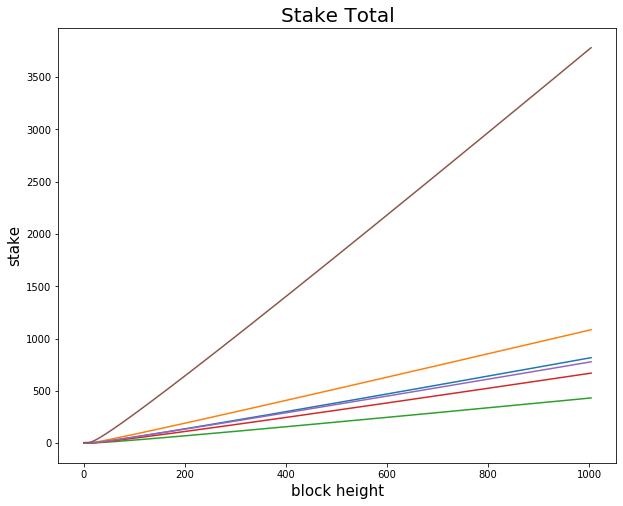

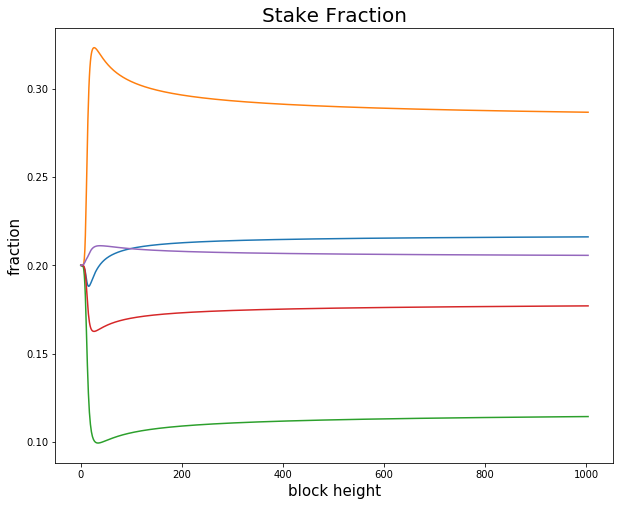

In [328]:

nodes = ['a', 'b', 'c', 'd', 'e']

edges = {'a': list(zip(['a', 'b', 'c', 'd'], [0.6, 0.1, 0.1, 0.2])),
         'b': list(zip(['b'], [1.0])),
         'c': list(zip(['c', 'a', 'd'], [0.4, 0.3, 0.3])),
         'd': list(zip(['d', 'a', 'b', 'c'], [0.5, 0.2, 0.1, 0.2])),
         'e': list(zip(['e'], [1.0]))
}
print ('Matrix Approximation Attribution:', str_arr(matrix_approximation(nodes, edges)))

       
# [trial] --> {id} --> ([block num], [stake])
data = []

trials = 1
blocks = 1000
for j in range(trials):
    
    data.append(
        {
         'a': ([0],[1]),
         'b': ([0],[1]),
         'c': ([0],[1]),
         'd': ([0],[1]),
         'e': ([0],[1]),
         'total': ([0],[5]),
        }
    )
    
    b = Bittensor()
    for k in nodes:
        b.subscribe(k)
        
    for k in nodes:
        b.emit(k, edges[k], inc_height = False)
    
    for i in range(blocks):
        for k in nodes:
            b.emit(k, edges[k], inc_height = False)
            data[j][k][1].append(b.stake[k])
            data[j][k][0].append(b.block_height)
        data[j]['total'][1].append(b.total)
        data[j]['total'][0].append(b.block_height)
        b.block_height += 1
            
    
import matplotlib.pyplot as plt
for trial in data:
    
    # plot total stake.
    plt.figure(figsize=(10,8))
    plt.title('Stake Total', fontsize=20)
    plt.xlabel('block height', fontsize=15)
    plt.ylabel('stake', fontsize=15)
    for k in nodes:
        plt.plot(trial[k][0], trial[k][1])      
    plt.plot(trial['total'][0], trial['total'][1])
    
    # plot stake fraction.
    plt.figure(figsize=(10,8))
    plt.title('Stake Fraction', fontsize=20)
    plt.xlabel('block height', fontsize=15)
    plt.ylabel('fraction', fontsize=15)
    for k in nodes:
        plt.plot(trial[k][0], [a/b for a,b in list(zip(trial[k][1], trial['total'][1]))])
        
    print ('Trial Attribution:', str_arr([trial[k][1][-1]/trial['total'][1][-1] for k in nodes]))
    
    break

    